# Self-driving car Nano Degree: Advanced Lane Lines

## Project feeling

In terms of code, I set for myself the goal to organise all the previous work in a single, easy to use piece of software. The size and complexity of a few functions was becoming too large to work comfortably in jupyter notebook. In addition, the requirement to track the lines from frame to frame and hints in the classroom pushed me toward an object oriented implementation. I am a beginner in Python, so this project was an opportunity to become familiar with Python modules, object-oriented features and also with the Python debugger, which saved me. Until this project, I knew nothing about the debugger.

Regarding the advanced lane lines project itself, I think it can be improved a lot for future students, and so can the course leading to it. The shortcomings from the course weight on the project and make it very academic in nature. Tracking items from frame to frame is introduced, but the Kalman filters, which are the right tool for the task, are only introduced at the beginning of term 2.

Let's summarize the project:

* Compute the camera calibration and apply distortion correction to images;
* Use color selection and masking to find lane line pixels on images;
* Use gradient approaches to find the lane lines;
* Warp image to bird-eye view in order to extract the geometry without the perspective effect;
* Render the extracted geometry and map it back on the original image;
* Compute the road curvature using the extracted geometry;
* Loop to process videos, and possibly include information from recent images in the detection tool chain.

I believe that this part of the course puts too much emphasis on colorspaces, without clearly making the point. Students understand what colorspaces are (I already knew), but the course does not explain how they connect with the topic. That's where we are left to believe that a robust lane detection algorithm can be built using colorspaces to look at different representations of pixel data. But that's plain wrong and misleading.

In the first lane lanes project, we boxed interesting pixels in a cube in RGB space. The tree on the side of the road projected a shadow which turned the white in gray, and it was difficult to continue tracking. So what are the more advanced methods of this project offering ?

Colorspaces index the available colors in different ways. Many tend to have hue and/or luminosity / luminance as axes. If we want to be robust to shadows, we need a rather large box in RGB space. The diagonal of that box extends from the bright white or yellow of a sunlit line, to the darker shade of the same color seen in a shadow. In different colorspaces, the boundaries defined by thresholds on various axes define other types of surfaces than cube faces in RGB space. But at the end of the process, we just delimited a volume in the colorspace (however you index it), which corresponds to "yellow" and "white" lane line pixels seen in various conditions. Using multiple colorspaces enables us to refine the definition of this volume, using separation surfaces which are not parallel to a constant R, a constant G or a constant B plane. We are doing by hand a job that supervised machine learning algorithms can do automatically.

The next figure is an example of annotated test images, that I used to automatically evaluate preprocessing pipelines. The alpha layer is used to isolate pixels belonging to lane boundaries, including the wall.

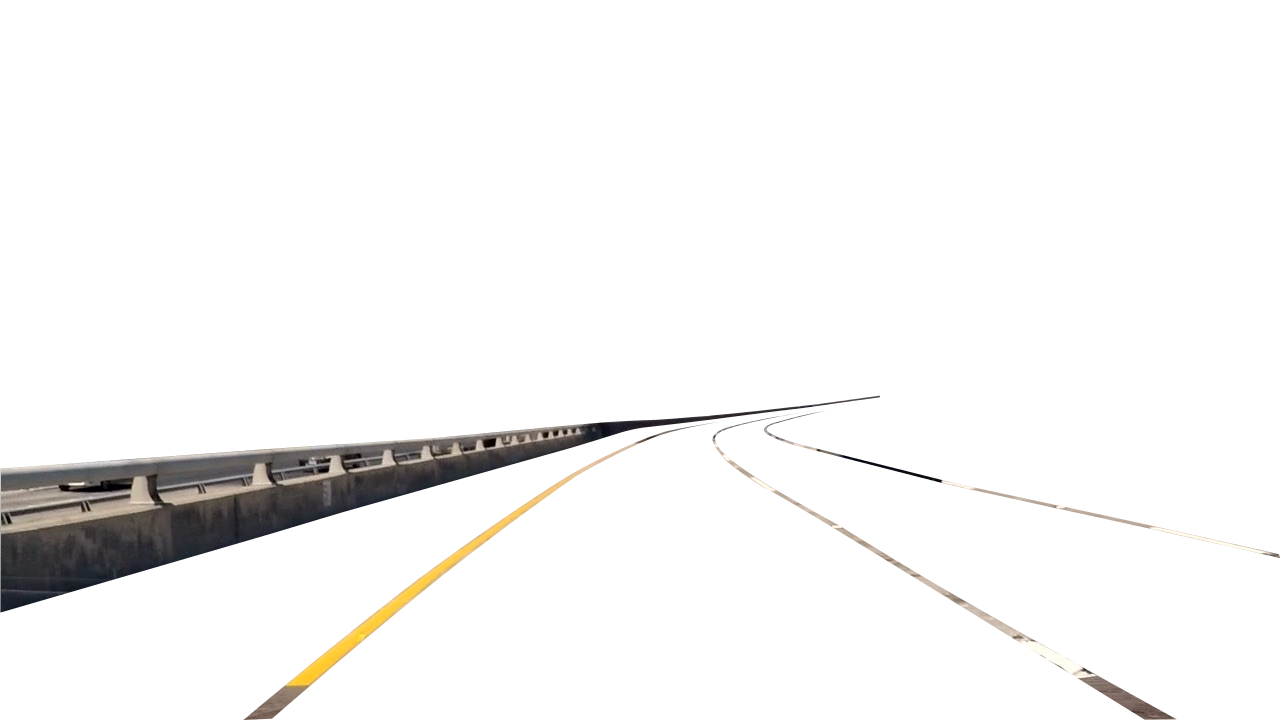

The academic side of the approach shows when it becomes apparent that any surface in a scene, can appear in any color. The course lacks an in-depth discussion of what color is, and why an approach in the colorspaces cannot work in real life. It can only work on sunny days. Each material can reflect color in a specific fashion, filtering in its own way the light components present in the incident light. Some materials can alter the frequency of light, shifting the color. Diffraction on water droplets make rainbow colors appear at pixel level. 

The lane lines can appear in any arbitrary color. This effect is clearly visible in neon lit street scenes under the rain: images show light from the colored neons reflected by water more than the lines. Under heavy rain at night, my experience as a driver tells me that it is not really possible to rely on the lane lines farther out than a few meters. But even in sunlight, we could have a color altering medium between the camera and the line, for instance a cloud of bluish engine exhaust, and the more we try to narrow what yellow and white mean for lane lines, the less robust we are to lighting, colored gases and rain, and paint color variations. Here in France, we also have blue lines delimiting time-limited parking spaces.

The next part of the course, on classifiers, gives us the right tools to classify pixels which can be lane lines, from those that cannot using machine learning approaches. And we could also have used a deep neural network to model this area of colorspace. 

## Personal objectives

I have set for myself the following goals, in addition to the objectifs stated in the Udacity project specifications:

* Deeper knowledge of Python
* Reusable library
* Ready for GPU implementation
* Robust algorithms


### The RoadImage library

The RoadImage library includes three classes:
* The RoadImage class, which relies on the other two;
* The Line abstract class, which encapsulates geometries;
* The CameraCalibration class, which stores camera calibration data and does all the 3D scene calculations.

In total, there are nearly four thousand lines of Python code, but a significant proportion of those are a consequence of my inexperience with that programming language.

is a specialization of the `numpy.ndarray` class. As a first approach to Python classes, it is not a straightforward example, but extending `numpy` is remarkably well documented.

A RoadImage instance is a collection of images (not a sequence, but possibly multiple camera images in parallel) represented as a N-dimensional `ndarray` where `N >= 3`. The last three dimensions must be height, width and depth of images, and even monochrome images have a depth dimension, equal to 1.

Internally, decorators flatten the collection, so that all the methods can rely on receiving 4 dimension arrays, where the dimensions are:

* 0: collection
* 1: height
* 2: width
* 3: channels (depth)

On top of methods available to all `numpy` arrays, the library offers the following additions:

* Image history:
  * parents
  * crop\_parents
  * children
  * list\_children
  * find\_child
  * shares\_data
  * copy
  * unlink
  * find\_common\_ancestor
  * find_op
  * select\_ops
  * get_crop
  * pretty\_print\_ops


* Data reorganization and views:
  * make_collection
  * flatten
  * channel
  * channels
  * rgb
  * crop


* Image transformation:
  * Per pixel
    * **convert_color**: Changes the colorspace.
    * to_grayscale
    * to_int
    * to_float
    * invert
    * **threshold**: Makes a binary image from a color or grayscale image.
    * apply\_mask
    * combine_masks
    
  * Global and morphologyical operators
    * **undistort**: Corrects distortion in an image using calibration data.
    * despeckle
    * dilate
    * erode
    * **extract\_lines**: Complex and slow image preprocessing pipeline.
    * resize
    * **gradients**: Optimized computation of one or more gradients, almost as explained in the classroom.
    * **integrate**: Turn signed gradient images back into unsigned ones.
    * **normalize**: Normalize pixel values to 100%, per image, per channel or per line.
    * warp_size
    * _warp_
    * _unwarp_
    * **curves**: Generic curve detection algorithm.
    * **find\_lines**: Final pipeline.
    * **centroids**: Enhanced centroids algorithm (not used).
    
    
* Information and utilities:
  * get_size : Get the width and depth of an image.
  * save : Save using the right channel order convention (matplotlib).
  * show : Safe image display layer atop imshow.

Key algorithms have been substantially modified from the baseline. 

The library has three key characteristics that are not required for the project: 
1. It remembers the transformations applied to an image, checks that requested operations are valid on the instance, and can explain how an image was obtained;
2. It is independent of the underlying representation of geometries, which is encapsulated in a class Line;
3. It tries hard to evaluate the quality of the proposed solutions.

The history is maintained with the idea that pipelines in the future can be prototyped interactively, then saved and reused with a single `apply` method. The current library tracks which images must be updated when an upstream image is modified. It does not currently offer this fully interactive mode, but prevents changes to images which would require updating downstream images. In order to support this features, it makes a distinction between derivative images which are views (`shares_data()` returns `True`) and other images.

Pipelines could also possibly be "compiled" for different hardware, such as the GPU. In the current implementation, history is used to automate finding the right information in sequences of operations. For instance, it is possible to unwarp a warped, cropped image to the right crop size using the correct inverse transformation, because the `CameraCalibration` data associated to the `warp` operation and the crop size are retrieved from the history of the image. 

The history of an image is a directed acyclic graph, where an image can serve as the basis for several other

The library remembers if an image has been undistorted, has been warped or unwarped, is binary (i.e. from a `threshold` operation) or is a signed gradient. The method `show` has specific provisions to display signed gradient image, either using a red-green scale (red for negative parts) when there is a single channel, or taking the absolute value when there are 2 or 3 channels.

The library checks for common errors, such as:
* Forgetting to undistort before warping;
* Thresholding a binary image (usually gives a black image);
* Unwarping an image, that was not first warped;
* Applying logic operations with `combine_masks` or morphological operations to non-binary operands;
* Applying `invert` or `integrate` to unsigned images;
* etc.

All the methods in `RoadImage` which deal with lane line geometries, do so through an instance of class `Line`. More exactly, since `Line` is an abstract class, it is an instance of class `LinePoly`, which implements polynomial models of lane lines, as explained in the classroom. All the geometries are represented by arbitrary python tuples, called "keys", chosen by the caller, except for a few default ones.

The instance is shared by all the related road images. A single instance of `Line` can store many geometries in a dictionary. The only constraint on keys, is that they should be suitable as python dictionary keys, and of course, tuples are a good choice.

The `Line` class offers the following interface:
* Properties:
  * zero : returns ('zero',), the default key for the line defined by equation `y = 0` (read-only).
  * one : returns ('one',), the key for `y = 1`.
  * color : the line color in RGB or RGBA
  * blink : make the representation blink
  * width : line width in the representation

* Management methods:
  * delete : delete a stored geometry
  * copy : copy a geometry to access it through another key
  * stats : generic getter of custom data associated to a geometry
  * set : generic setter of custom data associated to a geometry
  * exist : test if keys correspond to geometries
  
* Geometric operations
  * **move** : change the origin and orientation of the reference axes (used to update lane lines by dead reckoning)
  * **delta** : resolves the origin/orientation change between two geometries, assuming they describe the same line from two different points of view (used to measure the car speed)
  * **fit** : generates a geometry fitted to given points
  * **blend** : generates a geometry based on two others, using either a weighted sum or a weighted average
  * **eval** : computes Y=f(X) and derivatives, for the given X and geometry
  * **tangent** : simplifies a geometry which keeping it tangent in a given point to the original one, up to a given order
  * curvature : computes the curvature of a geometry at the given points

* Graphical operations
  * draw : draws the geometry in an image, using the defined color and width
  * draw_area : draws and fills the area between two geometries

In addition the `Line` instance is an iterable, which yields the keys of all the geometries it stores. The `LinePoly` class implements a polynomial approximation of curves. It is the default implementation a program gets when calling `Line.Factory()`. An particular implementation has to define all the geometric operations excepted `curvature`, which is defined in terms of `eval`.

Some linear algebra is needed to implement `delta` and `tangent`. Of course, `np.polyfit` is used to implement `fit`.

Because polynomial fitting relies on Vandermonde matrixes, it is well known that it is numerically unstable for large values of X and Y. The exponentiation of X creates a badly conditioned matrix. To improve this, making the Y as small as possible is a good idea. 

The method `fit` is key to our line finding application. 

## Camera calibration
Before we can use the camera images (test images and videos) we have to perform the camera calibration. The next cell uses the provided calibration images to compute a set of parameters which will be used later to compensate for optical distortion.

In [3]:
import numpy as np
import cv2
import glob
from classes import RoadImage
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
corners = None

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = RoadImage(filename=fname)               # Read to RGB pixel format
    gray = img.to_grayscale()

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
# Clean up workspace: keep only objpoints and imgpoints
del corners, gray, images, objp

from classes import CameraCalibration
# Create a calibration object for images 1280x720
cal = CameraCalibration(imgpoints = imgpoints, objpoints = objpoints, img_size = img.get_size())
#cal.save('camera_cal/calibration.p')

Let's see what we have...

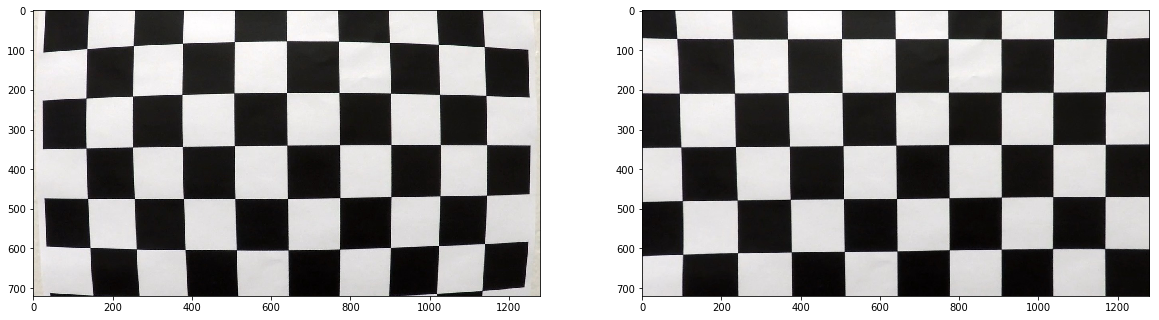

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

img = RoadImage(filename='camera_cal/calibration1.jpg')

# Do camera calibration given object points and image points
# Calibration is also relative to a given image size
#cal = CameraCalibration('camera_cal/calibration.p')

undist = img.undistort(cal)

f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(undist)

# Look good. Save cal.
cal.save('camera_cal/calibration.p')

The code cell above creates the two lists `objpoints` and `imgpoints` of matching 3D to 2D (pixel) coordinate pairs. This data is the input of the `CameraCalibration` constructor, which calculates the parameter set we need to undistort the images and stores it in the instance `cal`. Note that 3D coordinates are in an arbitrary set of axes, and in our case, the axes are local to the chessboard pattern, giving integer coordinates (0,0,0) to (8,5,0). All the points are in the Z=0 plane, which is the plane of the chessboard.

`CameraCalibration` is part of my object oriented package 'classes' (yes, I will rename it: i was discovering python classes, modules and packages for this project). The entire source code is available for review, but it is rather long and somewhat complex, and I have described it in greated detail later.

`CameraCalibration` is a class __which never handles pixels__. It was my first class, and I copied examples from the net to see how object oriented python worked. It contains useless functionality, such as a limitation of the number of instances of the class. Those parts will be deleted (everything is under version control with Git). They haven't yet because I focused on implementing useful functionality, and those useless parts work well and do no harm.

Beyond storing the information necessary to undistort the images, the class also handles all the geometry calculations (methods `lane_start()` at line 224, and `lane()` at line 258). Of course, it was possible to finish this project with a hardcoded trapeze warped into a rectangle and back. The method `lane()` actually computes the coordinates of the trapeze and the rectangle as a function of information provided by the camera calibration:
* Camera optical center: it gives the direction the image plane is orthogonal to, and it is available in the camera calibration matrix;
* Camera x-direction and y-direction focal length, which is relative to the sensor image size and directly gives the horizontal and vertical fields of view;
* Sensor image size, which has to be provided when the calibration and made, and which we store (the size is checked for each image we undistort);
* "Ahead" vector: pointing from the camera into the forward direction of the car;

I hope that I have correctly worked out the 3D geometry problem: the camera in our case is imperfect, but not very much, and errors in my equations might be difficult to notice in the result.
* The camera sensor size is 1280 x 720 pixels;
* The geometric center of that image is at (640, 360), but the optical center is slightly offset, at (670, 386);
* The focal length corresponds to a horizontal field of view of 58° and a vertical field of view of 35°; 
* The "ahead" vector points at pixel (638,418), roughly 1.6° to the left and down of the optical center;
* The height of the camera above the ground, measured at 1.275 m.

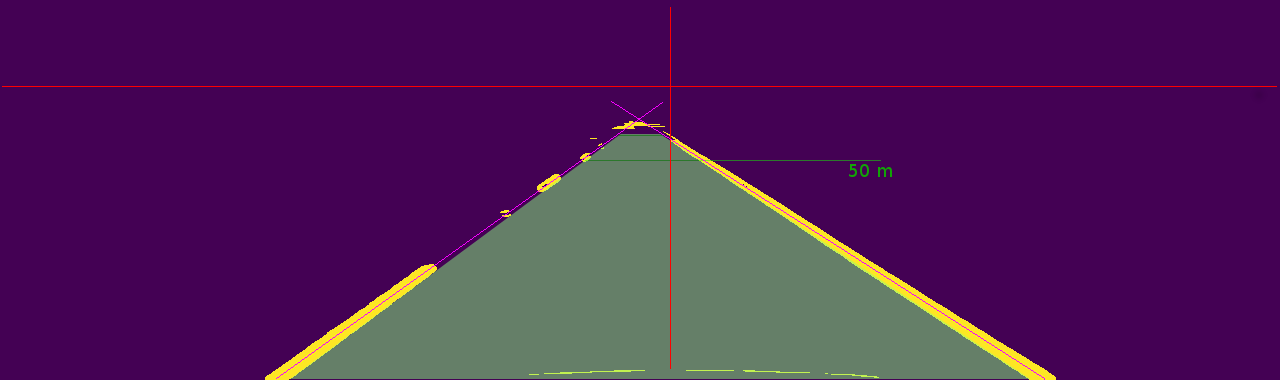

In addition to those never changing parameters (the first one depends on the camera model, the second on the camera instance, and the third and fourth mostly depend on the camera orientation and position relative to the car), the calculation depends on the relative height map, which is a height profile of the road transformed in the car axes given by the "ahead" vector. In those axes, it is not the absolute slope of the road which is described, but the increases or decreases of the slope.

The height profile is partially implemented. The video is made with the assumption of a flat road, but the slope of the road is actually changing.

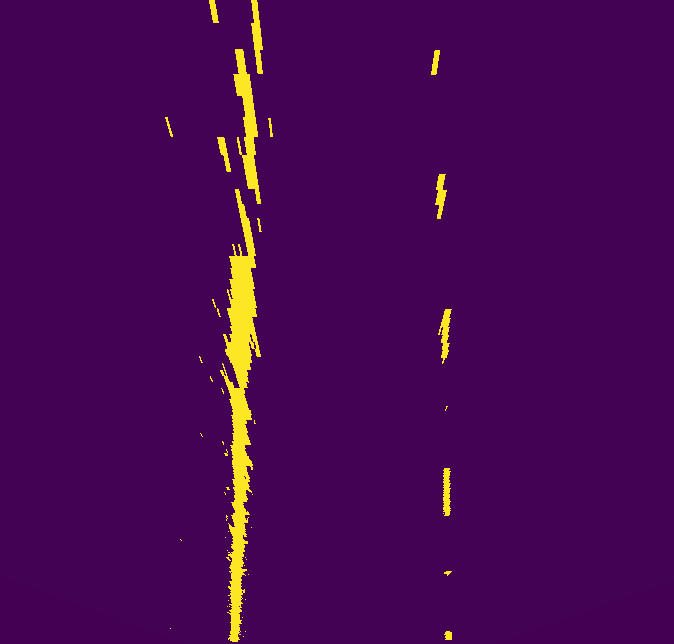

The image above is a composite image showing the lane line pixels for the `straight_lines1.jpg` test image. The scale is 2 cm/pixel in X and 10 cm/pixel in Y and the image is 644 pixels high (almost all the warped image examples use this scale, and a little bit more than 5 meters just ahead of the camera, are not visible in the images). 

It is noticeable that the lines are converging at the top, although they are parallel in reality. A small -18.6 cm correction at 70 meters from the camera makes them exactly parallel. It is reasonable to assume that the lanes are indeed parallel. With this assumption, we can interpret the varying lane width as height changes:
* The lane is too narrow when the height is negative (the road climbs less or descends more ahead);
* The lane is too wide when the height is positive (the road climbs more or descends less ahead).

Note that extracting the lane line pixels at 70 m requires a very good lane detection algorithm. Color alone will not achieve that, even in multiple colorspaces.

At line 324, you will notice that the returned rectangle is in reality a parallelogram. The trapeze is not symmetrical either, because its far end is offset since the camera points to the right of the "ahead" vector. 

I mentioned before that the optical center is important because it is the direction image planes are orthogonal to. Because the optical center is not vertically aligned with the ahead vector, those image planes do not cut the flat "road plane" (discounting the height map) on lines parallel to the X axis of the image. The top and bottom sides of the "rectangle" have a small angle because those sides are the intersection of the image planes passing at the start and the end of the depicted lane. 

Those small angles on the top and bottom sides of the "rectangle" allow the trapeze to have its top and bottom sides of course parallel to each other, but also parallel to the X direction of the image.

---

The next stage of analysis operates in a bird-eye view of the road. A view from above will make it a lot easier to calculate the geometry of the road ahead, especially the position of the car in the lane and the curvature of the road.

In order to get this view, we can rely on OpenCV's `warpPerspective` function. We will just assume that the road ahead lays in a plane having the exact same orientation as the road portion the car sits on. If this assumption isn't true, the lane lines will not be parallel, so we can possibly iterate later to fix that.

Given that assumption, an elongated rectangle of straight road ahead of the car looks like a trapeze in the camera image. We only need to find that trapeze on a suitable stretch of road, and project its four corners on the four corners of an elongated rectangle, representing the road seen from above. 

We will also take the opportunity of this projection to set the scale of the image. The height of the camera above the road sets the scale for everything else. In order to find an acceptable approximation to this figure, we will assume that the lane in the test image "straight_lines1.jpg" is exactly 3.7 meters. We can expect to have a lot more detail across the road, especially at short ranges, than alongside it, therefore we will employ rectangular pixels in the transformed picture. The resolution across the road must be fine enough to capture the thin lines, so we will pick 0.02 meters. In the direction of the road, 0.1 meters will be enough. A stripe 10 meters wide by 70 meters long will require 500 x 700 pixels.

Some calculations using the camera matrix lead to estimates of the field of view (58°), of the height of the camera above the road and give the pixel coordinates of the vertices defining a trapezoidal area representing a 40m long lane straight ahead. Coordinates are not obvious because the camera axis is slightly offset to the right and top. 

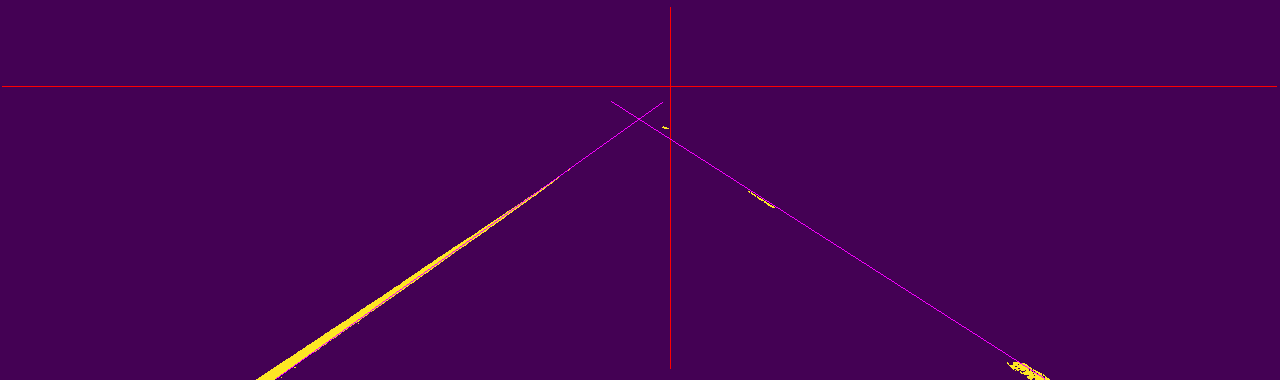

The comparison of the two straight line test images prooves that it is not the trajectory of the car that obliques across the lanes. On the two figures above, which show the lanes extracted from both straight line test images, the magenta lines which are in a separate layer, superpose exactly with the lane lines in both images. The arctangent of the pixel distance, divided by the pixel focal length (found in the camera matrix), gives the angles of misalignment : the camera axis is offset roughly 1.6° to the right and the top from the straight ahead axis defined by the road.

The center of the image is also available in the camera matrix. Taking into account the cropped areas at the top and bottom, the red lines in the figures above cross at the image center, at point (x=670, y=86). Let's consider the vertical plane parallel to the image plane, which meets the ground at the bottom edge of the image. The y coordinate is 379, the last line of the cropped image. The height of the camera axis is 294 pixel lines.

We need a known distance to calculate the scale of everything. The course teaches that the lane width is 3.7 meters. We can observe that the distance is 764 pixel horizontally. Given that those distances are in the same plane parallel to the image plane, the physical distances are proportional to the pixel distances: it gives us the height of the camera above the ground: 1.44 meters (actually the height of the camera axis as it crosses the plane).

Knowing that 3.7 meters appear as 764 pixels, we can convert the focal length to meters using proportionality. The focal length is 5.6 meters. Since the camera is not pointed straight ahead, the camera axis raises above the ground with distance with an angle of 1.6°. At z=70 meters, the small angle adds some to the camera height, which reaches 3.4 meters above the ground. The pixel offset from the image center, is equal to f y/z, using the focal length in pixels to obtain pixels. z can optionally be corrected for the small angle too.

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Mathematically computed trapeze (could be replaced by formulas for a changing slope)
# 40 m trapeze
#TRAPEZE=np.array([[275,379],[584.6,159.6],[691.4,159.6],[1030,379]], dtype=np.float32)
# 70 m trapeze
TRAPEZE=np.array([[275,379],[607.5,141.8],[668.5,141.8],[1030,379]], dtype=np.float32)
# X scale :  2 cm per pixel
# Y scale : 10 cm per pixel
# Receive 40 m in 400 pixels high image
#LANE=np.array([[157.5,399],[157.5,  0],[342.5,  0],[342.5,399]],  dtype=np.float32)
# Receive 70 m in 700 pixels high image
LANE=np.array([[157.5,699],[157.5,  0],[342.5,  0],[342.5,699]],  dtype=np.float32)

persp_mat = cv2.getPerspectiveTransform(TRAPEZE,LANE)
persp_mat_inv = cv2.getPerspectiveTransform(LANE,TRAPEZE)

def camera_to_birdeye(image,persp_mat):
    # Perspective transform
    birdeye_lanes = cv2.warpPerspective(image,  persp_mat, dsize=(500,700))
    return birdeye_lanes

# Demonstration
img = mpimg.imread('output_images/lines_test2.png')    # Read to RGB pixel format 

lanes = camera_to_birdeye(img[300:680],  persp_mat)

# Draw on images
for p1,p2 in zip(TRAPEZE[:3]+[0,300],TRAPEZE[1:]+[0,300]):
    cv2.line(img, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[255,0,0], thickness=3)

#show_lanes = cv2.cvtColor(lanes, cv2.COLOR_GRAY2RGB)
for p1,p2 in zip(LANE[:3],LANE[1:]):
    cv2.line(lanes, tuple(p1.astype(int)), tuple(p2.astype(int)), color=[1,0,0], thickness=3)

from classes import RoadImage

print(persp_mat)

print(img.shape)    
print(lanes.shape, np.min(lanes), np.max(lanes))
# Visualize masks

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
img.view(RoadImage).show(ax1, title='Input')

[[ -5.22778175e-01  -2.03499526e+00   5.79000933e+02]
 [ -2.10942375e-15  -6.28716949e+00   8.91520653e+02]
 [ -3.68628739e-18  -8.26781034e-03   1.00000000e+00]]
(720, 1280, 4)
(700, 500, 4) 0.0 1.0


The images show lane lines, 

In [4]:
from classes import RoadImage, CameraCalibration,Line
from classes.decorators import static_vars
import numpy as np

cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.set_camera_height(1.275)
cal.set_ahead(638,418)

@static_vars(counter=0, img=None)
def process_image(image):
    if process_image.img is None:
        process_image.img = RoadImage(image, src_cspace='RGB')
    else:
        np.copyto(process_image.img, image)
    # Save crash image (in case of crash)
    process_image.img.save('output_images/crash.jpg', format='jpg')
    # Do the work
    process_image.counter += 1
    overlay = process_image.img.find_lines(cal, method = RoadImage.centroids, save=True)
    overlay.save('output_images/videos/image%04d.png' 
                 % process_image.counter)
    out = overlay.to_int().copy()
    del overlay
    return out

AttributeError: 'CameraCalibration' object has no attribute 'set_camera_height'

origin = [215 700]
scoring: 0 -2.43263452431 0.268461751248
DEBUG: p(0,0)= ([15.608377960865795, -2.8460413593667733, 0.041340683505983813, 0.0],)
scores: cust=0.27  weight=0.04  derbounds=0.19
scoring: 0 -0.478390089958 0.950414447988
DEBUG: p(1,0)= ([3.7731598392498982, -0.55958903666703252, 0.0081198946708906702, 0.0],)
scores: cust=0.95  weight=0.08  derbounds=0.54
scoring: 0 -0.504347358159 0.94504206898
DEBUG: p(2,0)= ([3.9356992902761347, -0.58966112835641626, 0.0085313770196958037, 0.0],)
scores: cust=0.95  weight=0.08  derbounds=0.52
scoring: 0 -0.83183118065 0.857473386783
DEBUG: p(3,0)= ([5.7886963445004129, -0.97332416907439168, 0.014149298842421896, 0.0],)
scores: cust=0.86  weight=0.06  derbounds=0.35
scoring: 0 -0.00976179195542 0.999978824095
DEBUG: p(4,0)= ([0.77705585133362987, -0.011633784488619245, 0.00018719925332004255, 0.0],)
scores: cust=1.00  weight=0.62  derbounds=0.94
scoring: 0 -0.750965338101 0.882212796281
DEBUG: p(5,0)= ([5.3205511315158756, -0.8784627168

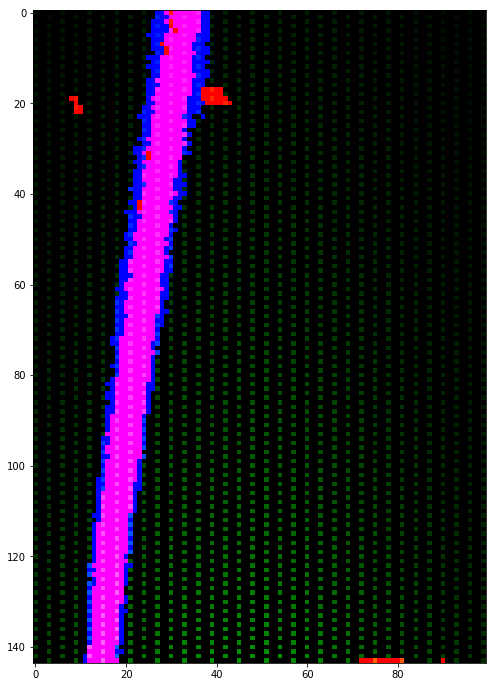

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
image = RoadImage(filename='test_images/test6.jpg')
image = process_image(image)

image=image.to_float()

width = 0.12
sx,sy = (.02,.1)
o = (215,700)

stepx = max(int(width/sx),2)
stepy = max(int(width/sy),2)
startx = stepx//2
starty = stepy//2
iterx  = stepx - startx
itery  = stepy - starty
#iters = ( (x,y) for y in range(1,651,stepy) for x in (3,430,stepx) )
w1 = np.array([ [ weight(y=(x-o[0])*sx+1,x=(o[1]-y)*sy,x0=1,z0=10.) for x in range(3,430,stepx) ] for y in range(1,651,stepy)])
w2 = np.array([ [ weight(y=(x-o[0])*sx+1,x=(o[1]-y)*sy,x0=1,z0=10.) for x in range(3+startx,430,stepx) ] for y in range(1+starty,651,stepy)])

image.view(np.ndarray)[1::stepy,3::stepx,1]=w1
image.view(np.ndarray)[1+starty::stepy,3+startx::stepx,1]=w2
image = image[500:644,120:220]
#image = image[1::stepy,3::stepx]

f, ax1 = plt.subplots(1,1, figsize=(20,12))
image.show(ax1)

In [15]:
with open('ramdisk/debug.csv','w') as f:
    f.write('"key";"index";"eval";"zmax";"order";"poly"\n')
    for K in RoadImage.find_lines.state.lines:
        poly = RoadImage.find_lines.state.lines.stats(K,'poly')
        data = RoadImage.find_lines.state.lines.stats(K,'eval','zmax','order')
        data = list(data)
        if len(K)>1:data.append(K[1])
        else:   data.append(0)
        poly = [ str(k) for k in poly]
        data = [ str(k) for k in data]
        msg = ';'.join([data[3],data[0],data[1],data[2],poly[0],poly[1],poly[2],poly[3],poly[4]])
    
        f.write('"'+str(K)+'";'+msg.replace('.',',')+'\n')


In [36]:
RoadImage.find_lines.__code__

<code object gsearch_wrapper at 0x7fc7701480c0, file "/home/jm/Projets/Udacity/CarND-Advanced-Lane-Lines/classes/decorators.py", line 193>

Separation... avoids scrolling

Initialization.
    journal = ramdisk/debug.csv
    keepdraw = 8
    track = True
    keepnext = 16
Initializing left line.
Initializing right line.


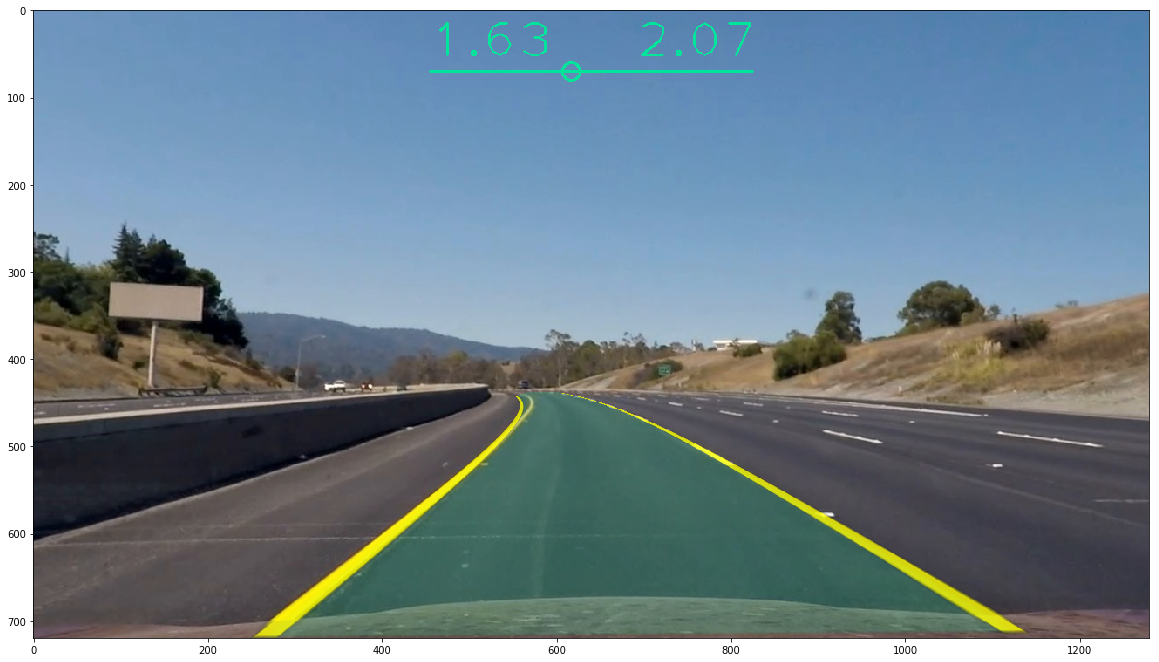

In [2]:
import numpy as np
import pdb
#%pdb

def myweight(x,y,x0=0.5,z0=100):
    return np.exp(-x**2/z0**2)*np.exp(-y**2/x0**2)

def plotweight(img, key, origin, scale, x0, z0):
    if not(img.lines.exist(key)): return
    w,h = img.get_size()
    ox,oy = origin
    sx,sy = scale
    for y in range(h):
        x=(oy-y)*sy
        yref = img.lines.eval(key,z=x)
        xx = np.arange(w)
        yy = np.ones_like(xx)*y
        weights = myweight(y=(xx-ox)*sx-yref,x=(oy-yy)*sy,x0=x0,z0=z0)
        img[y,:,1] = np.maximum(img[y,:,1], weights)
        
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

#file='input0001'
file='input0073'
#file='input0604'
#file='input1210'
#file='input1230'
#file='test1'
#file='test5'
#file='input0135'

image = RoadImage(filename='test_images/'+file+'.jpg')
#process_image.state=None
image = process_image(image)

f, ax1 = plt.subplots(1,1, figsize=(20,14))
image.show(ax1)

Warning: About to reinitialize!

In [1]:
from classes import CameraCalibration, RoadImage
from classes.decorators import static_vars
import pdb
#%pdb
cal = CameraCalibration('camera_cal/validation.p')
# Set the camera harmonization parameters for our car.
cal.camera_height=1.2
cal.set_ahead(638,418)

class State(object):
    pass

# Tunables
RoadImage.find_lines.state = State()
RoadImage.find_lines.state.counter  = 0
RoadImage.find_lines.state.keepdraw = 8
RoadImage.find_lines.state.keepnext = 16
RoadImage.find_lines.state.journal = 'ramdisk/debug.csv'
RoadImage.find_lines.state.track = True
#with open(RoadImage.find_lines.state.journal, 'w') as f:
#    f.write('"key";"index";"eval";"zmax";"order";"poly"\n')

@static_vars(state=None)
def process_image(image):
    img = RoadImage(image, src_cspace='RGB')
    img = img.undistort(cal)
    #img.normalize(inplace=True, perchannel=False, perline=True)

    img = img.find_lines(cal)

    process_image.state = RoadImage.find_lines.state
    return img

Make the video.

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pdb
%pdb
def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

file = 'project_video.mp4'
#file = 'challenge_video.mp4'

output = 'output_images/'+file
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip(file).subclip(37,42)
#clip1 = VideoFileClip(file).subclip(37,38)
#clip1 = VideoFileClip(file).subclip(20,25)
clip1 = VideoFileClip(file)
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Automatic pdb calling has been turned ON
Initialization.
    keepdraw = 8
    keepnext = 16
Initializing left line.
Initializing right line.
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



 12%|█▏        | 152/1261 [05:54<44:22,  2.40s/it]


 14%|█▍        | 180/1261 [07:20<1:12:46,  4.04s/it]

Lost sync! ev 0.3646 < 0.5058 initial_eval



 14%|█▍        | 181/1261 [07:22<1:00:20,  3.35s/it]

Lost sync! ev 0.3486 < 0.5305 initial_eval



 15%|█▍        | 183/1261 [07:25<43:00,  2.39s/it]

Lost sync! ev 0.3056 < 0.4242 initial_eval



 25%|██▍       | 315/1261 [12:22<41:48,  2.65s/it]

Lost sync! ev 0.3562 < 0.4660 initial_eval



 26%|██▌       | 327/1261 [12:43<27:33,  1.77s/it]

Lost sync! ev 0.3603 < 0.4566 initial_eval



 26%|██▌       | 328/1261 [12:45<27:05,  1.74s/it]

Lost sync! ev 0.3500 < 0.4517 initial_eval



 26%|██▌       | 329/1261 [12:46<26:22,  1.70s/it]

Lost sync! ev 0.3690 < 0.4702 initial_eval



 26%|██▌       | 330/1261 [12:48<26:19,  1.70s/it]

Lost sync! ev 0.3895 < 0.4933 initial_eval



 27%|██▋       | 339/1261 [13:03<25:17,  1.65s/it]

Lost sync! ev 0.3664 < 0.4742 initial_eval



 27%|██▋       | 340/1261 [13:04<24:55,  1.62s/it]

Lost sync! ev 0.3678 < 0.4897 initial_eval



 27%|██▋       | 341/1261 [13:06<25:10,  1.64s/it]

Lost sync! ev 0.3760 < 0.4720 initial_eval



 34%|███▎      | 423/1261 [15:30<24:01,  1.72s/it]

Lost sync! ev 0.3511 < 0.4433 initial_eval



 35%|███▍      | 436/1261 [15:52<24:06,  1.75s/it]

Lost sync! ev 0.3773 < 0.4809 initial_eval



 36%|███▋      | 460/1261 [16:34<22:18,  1.67s/it]

Lost sync! ev 0.3818 < 0.4816 initial_eval



 37%|███▋      | 461/1261 [16:35<21:36,  1.62s/it]

Lost sync! ev 0.3871 < 0.4868 initial_eval



 47%|████▋     | 587/1261 [21:57<29:05,  2.59s/it]

Lost sync! ev 0.3998 < 0.5496 initial_eval



 48%|████▊     | 599/1261 [22:25<28:36,  2.59s/it]

Lost sync! ev 0.2411 < 0.3031 initial_eval



 48%|████▊     | 604/1261 [22:40<30:28,  2.78s/it]

Lost sync! ev 0.3278 < 0.4461 initial_eval



 48%|████▊     | 605/1261 [22:43<32:35,  2.98s/it]

Lost sync! ev 0.3140 < 0.3942 initial_eval



 48%|████▊     | 609/1261 [22:58<40:02,  3.68s/it]

Lost sync! ev 0.3233 < 0.4278 initial_eval



 51%|█████     | 640/1261 [24:42<24:13,  2.34s/it]

Lost sync! ev 0.3557 < 0.4751 initial_eval



 51%|█████     | 642/1261 [24:46<22:16,  2.16s/it]

Lost sync! ev 0.3835 < 0.4901 initial_eval



 59%|█████▊    | 738/1261 [27:46<17:10,  1.97s/it]

Lost sync! ev 0.4103 < 0.5226 initial_eval



 59%|█████▊    | 740/1261 [27:49<15:26,  1.78s/it]

Lost sync! ev 0.4292 < 0.5438 initial_eval



 59%|█████▉    | 748/1261 [28:03<14:47,  1.73s/it]

Lost sync! ev 0.4555 < 0.5723 initial_eval



 59%|█████▉    | 750/1261 [28:06<15:09,  1.78s/it]

Lost sync! ev 0.3983 < 0.5169 initial_eval



 60%|█████▉    | 752/1261 [28:10<14:12,  1.67s/it]

Lost sync! ev 0.4199 < 0.5506 initial_eval



 60%|█████▉    | 755/1261 [28:15<15:24,  1.83s/it]

Lost sync! ev 0.4559 < 0.5770 initial_eval



 61%|██████▏   | 773/1261 [28:55<18:12,  2.24s/it]

Lost sync! ev 0.4311 < 0.5538 initial_eval



 61%|██████▏   | 774/1261 [28:57<18:02,  2.22s/it]

Lost sync! ev 0.3947 < 0.5014 initial_eval



 61%|██████▏   | 775/1261 [28:59<17:09,  2.12s/it]

Lost sync! ev 0.3953 < 0.4983 initial_eval



 62%|██████▏   | 777/1261 [29:03<15:10,  1.88s/it]

Lost sync! ev 0.4362 < 0.5566 initial_eval



 62%|██████▏   | 778/1261 [29:04<14:43,  1.83s/it]

Lost sync! ev 0.4367 < 0.5463 initial_eval



 62%|██████▏   | 786/1261 [29:19<15:25,  1.95s/it]

Lost sync! ev 0.3864 < 0.4953 initial_eval



 64%|██████▍   | 810/1261 [30:10<16:53,  2.25s/it]

Lost sync! ev 0.4114 < 0.5404 initial_eval



 65%|██████▌   | 820/1261 [30:28<13:53,  1.89s/it]

Lost sync! ev 0.4410 < 0.5612 initial_eval



 65%|██████▌   | 821/1261 [30:30<13:44,  1.87s/it]

Lost sync! ev 0.4083 < 0.5260 initial_eval



 65%|██████▌   | 822/1261 [30:31<13:04,  1.79s/it]

Lost sync! ev 0.3878 < 0.4920 initial_eval



 65%|██████▌   | 823/1261 [30:33<12:41,  1.74s/it]

Lost sync! ev 0.4221 < 0.5328 initial_eval



 65%|██████▌   | 824/1261 [30:34<12:11,  1.68s/it]

Lost sync! ev 0.4214 < 0.5329 initial_eval



 66%|██████▌   | 832/1261 [30:51<15:46,  2.21s/it]

Lost sync! ev 0.4267 < 0.5385 initial_eval



 66%|██████▌   | 833/1261 [30:53<16:06,  2.26s/it]

Lost sync! ev 0.3945 < 0.5107 initial_eval



 67%|██████▋   | 845/1261 [31:15<11:26,  1.65s/it]

Lost sync! ev 0.3854 < 0.5162 initial_eval



 67%|██████▋   | 846/1261 [31:16<11:15,  1.63s/it]

Lost sync! ev 0.3811 < 0.4912 initial_eval



 68%|██████▊   | 856/1261 [31:37<14:54,  2.21s/it]

Lost sync! ev 0.4040 < 0.5177 initial_eval



 75%|███████▍  | 940/1261 [33:53<09:02,  1.69s/it]

Lost sync! ev 0.3827 < 0.4789 initial_eval



 79%|███████▉  | 1000/1261 [36:47<08:41,  2.00s/it]

Lost sync! ev 0.2773 < 0.3599 initial_eval



 82%|████████▏ | 1036/1261 [38:32<13:04,  3.49s/it]

Lost sync! ev 0.3670 < 0.4597 initial_eval



 83%|████████▎ | 1046/1261 [38:57<07:03,  1.97s/it]

Lost sync! ev 0.3659 < 0.4662 initial_eval



 84%|████████▍ | 1058/1261 [39:18<05:52,  1.74s/it]

Lost sync! ev 0.3867 < 0.4939 initial_eval



 93%|█████████▎| 1173/1261 [42:28<02:29,  1.70s/it]

Lost sync! ev 0.3837 < 0.4979 initial_eval



 99%|█████████▉| 1251/1261 [44:47<00:18,  1.81s/it]

Lost sync! ev 0.3629 < 0.4583 initial_eval



 99%|█████████▉| 1252/1261 [44:49<00:16,  1.81s/it]

Lost sync! ev 0.3694 < 0.4744 initial_eval



 99%|█████████▉| 1253/1261 [44:51<00:14,  1.77s/it]

Lost sync! ev 0.3877 < 0.4891 initial_eval



100%|█████████▉| 1260/1261 [45:03<00:01,  1.88s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 51min 56s, sys: 1h 10s, total: 1h 52min 7s
Wall time: 45min 5s
